In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [23]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'GOOGL'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
stock_data = tickerData.history(period='1wk', start='2010-1-1', end='2023-3-14')

In [25]:
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,15.689439,15.753504,15.621622,15.684434,78169752,0.0,0.0
2010-01-05 00:00:00-05:00,15.695195,15.711712,15.554054,15.615365,120067812,0.0,0.0
2010-01-06 00:00:00-05:00,15.662162,15.662162,15.174174,15.221722,158988852,0.0,0.0
2010-01-07 00:00:00-05:00,15.250250,15.265265,14.831081,14.867367,256315428,0.0,0.0
2010-01-08 00:00:00-05:00,14.814815,15.096346,14.742492,15.065566,188783028,0.0,0.0
...,...,...,...,...,...,...,...
2023-03-07 00:00:00-05:00,94.980003,95.669998,93.529999,93.860001,27835500,0.0,0.0
2023-03-08 00:00:00-05:00,94.120003,95.959999,94.000000,94.250000,34103300,0.0,0.0
2023-03-09 00:00:00-05:00,94.050003,95.529999,91.900002,92.320000,28813500,0.0,0.0


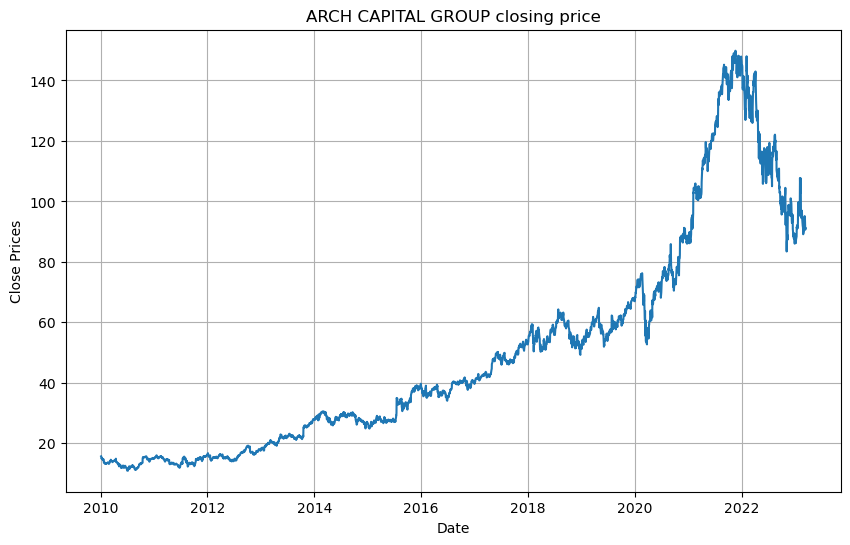

In [6]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('closing price')
plt.show()

<Axes: ylabel='Density'>

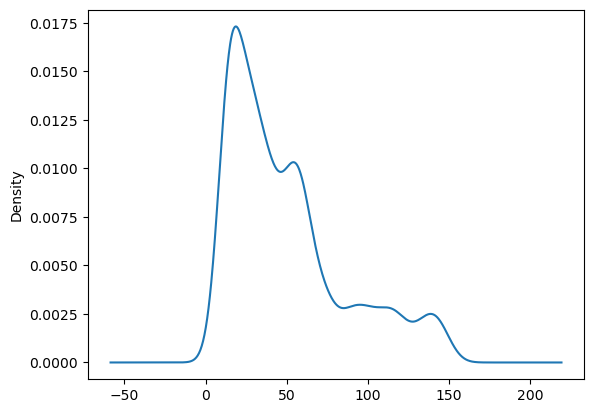

In [7]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

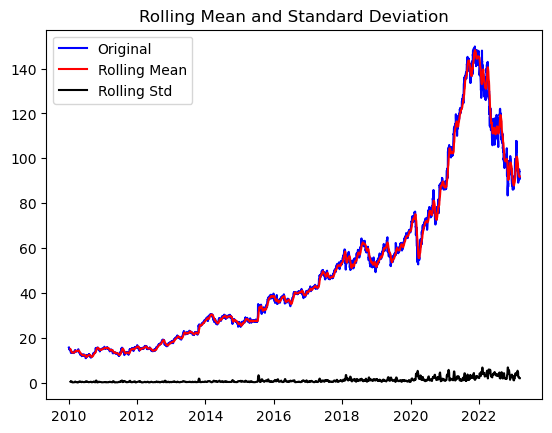

Results of dickey fuller test
Test Statistics                  -0.553755
p-value                           0.881093
No. of lags used                 23.000000
Number of observations used    3296.000000
critical value (1%)              -3.432336
critical value (5%)              -2.862417
critical value (10%)             -2.567237
dtype: float64


In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

In [9]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
#result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
#fig = plt.figure()  
#fig = result.plot()  
#fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


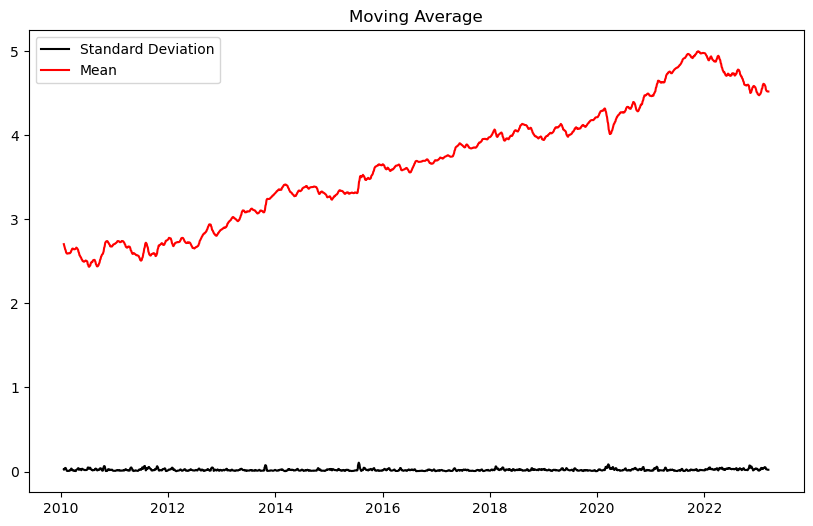

In [10]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

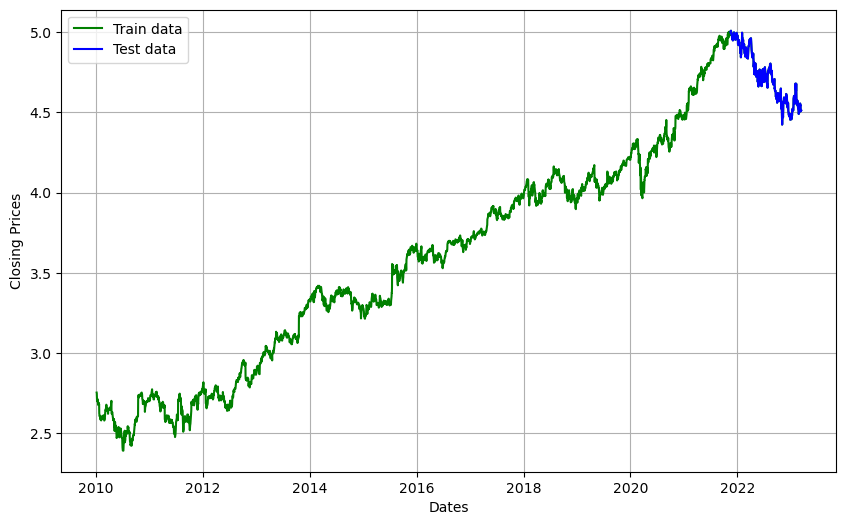

In [11]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16127.284, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16122.863, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16128.416, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16128.162, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16118.121, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16127.244, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16123.953, Time=1.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16122.988, Time=0.21 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 5.235 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2985
Model:               SARIMAX(1, 1, 0)   Log Likelihood                8067.208
Date:                Wed, 15 Mar 2023   AIC                         -16128.416
Time:               

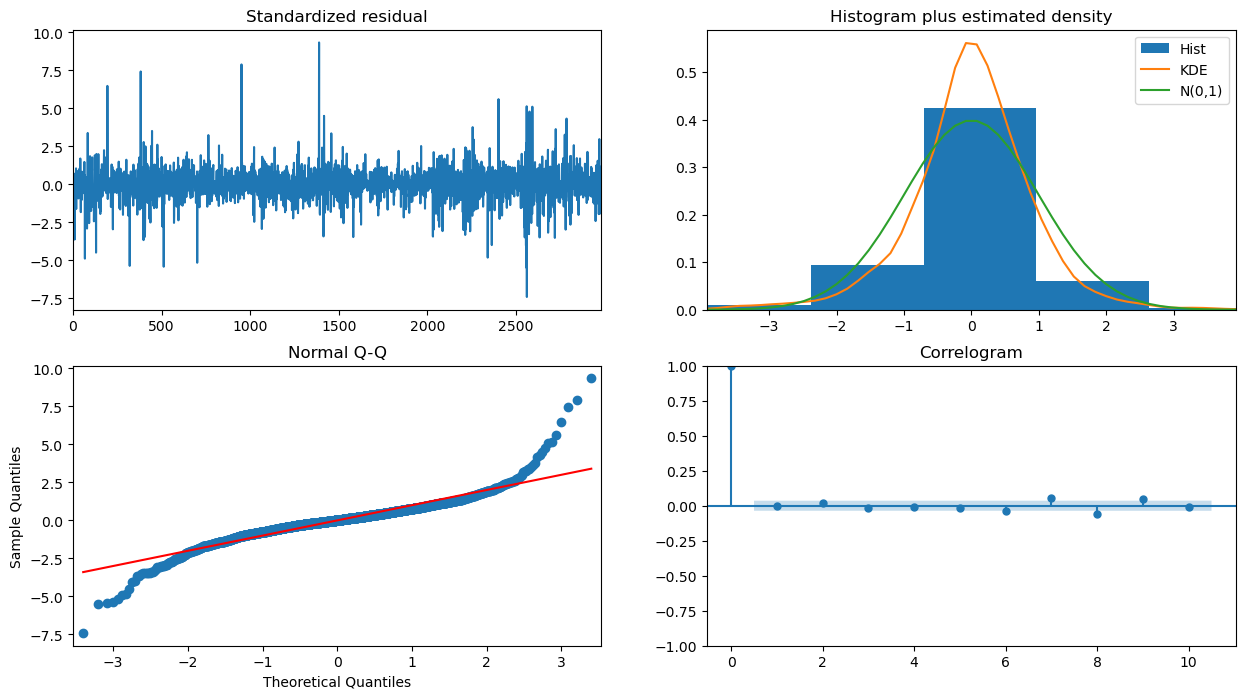

In [27]:
model_autoARIMA = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [16]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,0))  
fitted = model.fit()
#fitted = model.fit(disp=-1)

print(fitted.summary())

c:\Users\DimiP\miniconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\DimiP\miniconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\DimiP\miniconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2985
Model:                 ARIMA(1, 1, 0)   Log Likelihood                8063.494
Date:                Wed, 15 Mar 2023   AIC                         -16122.988
Time:                        14:29:33   BIC                         -16110.986
Sample:                             0   HQIC                        -16118.670
                               - 2985                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0480      0.012     -3.903      0.000      -0.072      -0.024
sigma2         0.0003   2.87e-06     91.693      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [26]:
# Forecast
fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

c:\Users\DimiP\miniconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: too many values to unpack (expected 3)

In [13]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

NameError: name 'fc' is not defined